In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import matplotlib.image as mpimg
from collections import Counter


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [3]:
conn = sqlite3.connect("im.db")

cur = conn.cursor()

movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")

movie_budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding='ISO-8859-1')

movie_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep='\t', encoding='ISO-8859-1')
movie_info.head()

#pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table';""", conn)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


#### Check Missing Values in Movie Info Dataset

In [4]:
# Read the TSV file
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", sep='\t', encoding='ISO-8859-1')

# Get missing values count and percentage

missing_values = movie_info.isnull().sum()

missing_percentage = (movie_info.isnull().sum() / len(movie_info)) * 100

# Create a summary dataframe

missing_summary_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage})

# Sort by percentage missing
missing_summary = missing_summary_df.sort_values('Percentage Missing', ascending=False);

missing_summary



,Missing Values,Percentage Missing
currency,1220,78.205128
box_office,1220,78.205128
studio,1066,68.333333
writer,449,28.782051
theater_date,359,23.012821
dvd_date,359,23.012821
director,199,12.756410
synopsis,62,3.974359
runtime,30,1.923077
genre,8,0.512821


#### Cleaning the Dataset

In [5]:
# Drop columns with more than 50% missing values

cols_to_drop = missing_summary[missing_summary['Percentage Missing'] > 50].index

# Drop these columns
df_cleaned = movie_info.drop(columns=cols_to_drop)

# Fill numeric columns with median
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

#Fill categorical columns with mode
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

# Check if there are any remaining missing values
remaining_missing = df_cleaned.isnull().sum().sum()

print("\
Remaining Missing Values:", remaining_missing)

Remaining Missing Values: 0


In [6]:
#Check individual columns for any missing values
df_cleaned.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
runtime         0
dtype: int64

In [7]:
#Check the first five rows of the cleaned dataset
df_cleaned.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,runtime
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",116 minutes
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",128 minutes
4,7,A group of air crash survivors are stranded in...,NR,Drama|Romance,Rodney Bennett,Giles Cooper,"Jan 1, 1987","Jun 1, 2004",200 minutes


In [8]:
# split the genre column into a list of genres
df_cleaned['genre_list'] = df_cleaned['genre'].str.split('|')

# Explode to create a new row for each genre
df_cleaned_exploded = df_cleaned.explode('genre_list')

# Display the first few rows
df_cleaned_exploded.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,runtime,genre_list
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Science Fiction and Fantasy


In [9]:
# Remove the genre_column
df_cleaned_exploded = df_cleaned_exploded.drop('genre', axis=1)
df_cleaned_exploded

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre_list
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",108 minutes,Science Fiction and Fantasy
...,...,...,...,...,...,...,...,...,...
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Steven Spielberg,Luc Besson,"Sep 27, 2001","Feb 11, 2003",94 minutes,Action and Adventure
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Steven Spielberg,Luc Besson,"Sep 27, 2001","Feb 11, 2003",94 minutes,Art House and International
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Steven Spielberg,Luc Besson,"Sep 27, 2001","Feb 11, 2003",94 minutes,Comedy
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Steven Spielberg,Luc Besson,"Sep 27, 2001","Feb 11, 2003",94 minutes,Drama


In [10]:
# Rename the genre_list column to genre
updated_df = df_cleaned_exploded.rename(columns={'genre_list': 'genre'})

updated_df.head(3)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104 minutes,Drama


In [11]:
# Extract numeric values from the 'runtime' column
updated_df['runtime'] = updated_df['runtime'].str.extract('(\d+)').astype(float)

updated_df.head(2)

,id,synopsis,rating,director,writer,theater_date,dvd_date,runtime,genre
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",104.0,Classics


#### Checking the cleaned DataFrame Data Types

In [12]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3581 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3581 non-null   int64  
 1   synopsis      3581 non-null   object 
 2   rating        3581 non-null   object 
 3   director      3581 non-null   object 
 4   writer        3581 non-null   object 
 5   theater_date  3581 non-null   object 
 6   dvd_date      3581 non-null   object 
 7   runtime       3581 non-null   float64
 8   genre         3581 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 279.8+ KB


In [13]:
#Convert the dates to Date Time format
updated_df['theater_date'] = pd.to_datetime(df_cleaned_exploded['theater_date'])

updated_df['dvd_date'] = pd.to_datetime(df_cleaned_exploded['dvd_date'])


In [14]:
#Confirming the format has been updated

updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3581 entries, 0 to 1559
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3581 non-null   int64         
 1   synopsis      3581 non-null   object        
 2   rating        3581 non-null   object        
 3   director      3581 non-null   object        
 4   writer        3581 non-null   object        
 5   theater_date  3581 non-null   datetime64[ns]
 6   dvd_date      3581 non-null   datetime64[ns]
 7   runtime       3581 non-null   float64       
 8   genre         3581 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 279.8+ KB


#### Check Missing Values in Movie Budget Dataset 

In [15]:
# Get missing values count and pct

missing_values_budgets = movie_budget.isnull().sum()

missing_percentage_budgets = (movie_budget.isnull().sum() / len(movie_budget)) * 100

# Combine into a summary dataframe
missing_summary_budgets = pd.DataFrame({
    'Missing Values': missing_values_budgets,
    'Percentage Missing': missing_percentage_budgets})

missing_summary_budgets

,Missing Values,Percentage Missing
id,0,0.0
release_date,0,0.0
movie,0,0.0
production_budget,0,0.0
domestic_gross,0,0.0
worldwide_gross,0,0.0


#### The Movie Budget dataset has no missing values

In [16]:
#Checking the first 5 rows
movie_budget.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
#Remove the dollar sign from the numerical columns
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:

    movie_budget[col] = movie_budget[col].replace({'\\$': '', ',': ''}, regex=True).astype(float)

# Display the cleaned data types and head of the dataframe to confirm changes

print(movie_budget[['production_budget', 'domestic_gross', 'worldwide_gross']].head())

   production_budget  domestic_gross  worldwide_gross
0        425000000.0     760507625.0     2.776345e+09
1        410600000.0     241063875.0     1.045664e+09
2        350000000.0      42762350.0     1.497624e+08
3        330600000.0     459005868.0     1.403014e+09
4        317000000.0     620181382.0     1.316722e+09


In [18]:
#Check first five rows of movie_budget
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [19]:
# checking the data types of movie_budget
movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


In [20]:
#Convert the release date to DateTime Format
movie_budget["release_date"] = pd.to_datetime(movie_budget['release_date'])

movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


##### The movie_budget Dataset is now clean and ready for EDA

### Checking Missing Values in the Movie Gross Dataset

In [21]:
# Load the dataset
movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")

# Check missing values
missing_values = movie_gross.isnull().sum()

missing_percentage = (movie_gross.isnull().sum() / len(movie_gross)) * 100

# Create a summary dataframe
missing_summary_gross = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_percentage})


missing_summary_gross

,Missing Values,Percentage Missing
title,0,0.000000
studio,5,0.147623
domestic_gross,28,0.826690
foreign_gross,1350,39.858282
year,0,0.000000


The dataset has missing values primarily in the foreign_gross column, with a smaller number in domestic_gross and studio

### Cleaning the dataset
To clean the data, I'll remove rows with missing values in the studio and domestic_gross columns due to their small number, and consider imputing or removing rows with missing foreign_gross values based on their impact on analysis. 

In [22]:
# Remove rows with missing values in 'studio' and 'domestic_gross' columns
cleaned_movie_gross = movie_gross.dropna(subset=['studio', 'domestic_gross'])

# Making a copy of the DataFrame
cleaned_movie_gross = movie_gross.dropna(subset=['studio', 'domestic_gross']).copy()

# Fill Missing Values in 'foreign_gross' with 0
cleaned_movie_gross['foreign_gross'] = cleaned_movie_gross['foreign_gross'].fillna(0)

#Checking if there are any Missing Values
cleaned_movie_gross.isna().sum()


title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [23]:
#Checking the Data Types of the Movie Gross Dataset
cleaned_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   3356 non-null   object 
 4   year            3356 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 157.3+ KB


In [24]:
#Convert the data type of foreign gross to numeric

cleaned_movie_gross['foreign_gross'] = cleaned_movie_gross['foreign_gross'].replace(',', '', regex=True).astype(float)

#Confirming the changes
cleaned_movie_gross.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   3356 non-null   float64
 4   year            3356 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB


### The three Datasets namely Movie Gross, Movie Budget and Movie Info are now clean and ready for EDA

In [25]:
#Merging Movie_info Dataset with Movie_budget Dataset
merged_df = pd.merge(updated_df, movie_budget, on='id', how='inner')

#check for any missing values in merged_df
merged_df.isna().sum()

id                   0
synopsis             0
rating               0
director             0
writer               0
theater_date         0
dvd_date             0
runtime              0
genre                0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

# EDA

# Objectives:
1. Identify Top-Performing Genres: Determine which film genres are currently performing best at the box office.

2. Analyze Trends: Look at trends in audience preferences and box office performance over recent years.

3. Understand Audience Demographics: Identify the demographics of audiences for top-performing genres.

4. Evaluate Production Costs: Consider the production costs associated with different genres.

5. Provide Actionable Insights: Translate findings into actionable insights for the new movie studio.

# Steps to Achieve Objectives:
1. Do Research on Data: Using the given sources to gather data on revenues by genre.

2. Analyzing Historical Performance: Look at the historical performance of different genres to identify trends and patterns.

3. Survey Audience Preferences: Conduct surveys or focus groups to understand audience preferences and demographics. 

4. Evaluate Production Costs: Research the typical production costs for different genres to understand budget implications.

5. Compile Findings: Summarize findings in a report that highlights the top-performing genres and production costs.

6. Provide Recommendations: Based on findings, provide recommendations on which genres the new movie studio should consider producing.

# Actionable Insights:
1. Focus on High-Performing Genres: Prioritize genres like action, adventure, and superhero films, which have historically performed well at the box office2.

2. Consider Audience Demographics: Tailor content to appeal to key demographics, such as younger audiences for action and adventure films, and family audiences for animated films3.

3. Leverage Franchise Potential: Explore opportunities to create or acquire franchise properties, as franchises tend to perform well and have built-in audiences.

4. Balance Budget and Potential Returns: Balance production costs with potential box office returns, considering that some genres may require higher budgets but also offer higher returns3.

5. Stay Updated on Trends: Continuously monitor industry trends and audience preferences to adapt and innovate in content creation.

# EDA Techniques for Box Office Data:
## 1. Summary Statistics:

    Calculate mean, median, and mode of movie revenues.

    Determine the standard deviation and range to understand the spread of the data.

## 2. Distribution Analysis:

    Create histograms to visualize the distribution of box office revenues for different genres.

    Use box plots to identify outliers and understand the spread of revenue data.

## 3. Trend Analysis:

    Plot time series graphs to analyze box office revenue trends over the years.

    Identify seasonal patterns and trends in movie releases and revenues.

## 4. Genre Analysis:

    Use bar charts to compare the average box office revenues for different genres.

    Analyze the frequency of each genre to see which are most common and which are rare.

## 5. Correlation Analysis:

    Calculate correlation coefficients to identify relationships between variables (e.g., budget and box office revenue).

    Create scatter plots to visualize these relationships.

## 6. Demographic Analysis:

    Analyze audience demographics (age, gender, location) for top-performing movies.

    Use pie charts or bar charts to visualize the distribution of demographics.

## 7. Box Office Performance by Release Date:

    Investigate the impact of release dates on box office performance.

    Create heatmaps to visualize revenue performance across different months and years.

## 8. Production Cost Analysis:

    Compare production costs across different genres and their box office returns.

    Use scatter plots to visualize the relationship between production costs and revenues.

In [26]:
movie_budget.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

## 1. Profit Analysis
Calculating profit by subtracting production_budget from worldwide_gross for each movie.

In [27]:
# Calculate profit
movie_budget['profit'] = movie_budget['worldwide_gross'] - movie_budget['production_budget']

# Selecting only the 'movie' and 'profit' columns to create a new DataFrame
profit_df = movie_budget[['movie', 'profit']]

# Display the resulting DataFrame
profit_df.head()


,movie,profit
0,Avatar,2.351345e+09
1,Pirates of the Caribbean: On Stranger Tides,6.350639e+08
2,Dark Phoenix,-2.002376e+08
3,Avengers: Age of Ultron,1.072414e+09
4,Star Wars Ep. VIII: The Last Jedi,9.997217e+08


## 2. Return on Investment (ROI): 
Calculating the ROI as a percentage, which is (profit / production_budget) * 100.

In [28]:
movie_budget['ROI (%)'] = (movie_budget['profit'] / movie_budget['production_budget']) * 100

Roi_calc = movie_budget[['movie', 'production_budget', 'profit', 'ROI (%)']]

Roi_calc.head()

,movie,production_budget,profit,ROI (%)
0,Avatar,425000000.0,2.351345e+09,553.257713
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,6.350639e+08,154.667286
2,Dark Phoenix,350000000.0,-2.002376e+08,-57.210757
3,Avengers: Age of Ultron,330600000.0,1.072414e+09,324.384139
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,9.997217e+08,315.369636


# 3. Domestic vs. Worldwide Revenue Comparison
Calculate the domestic revenue percentage of the worldwide gross to see the dependency on the domestic market.

In [29]:
movie_budget['domestic_percentage'] = (movie_budget['domestic_gross'] / movie_budget['worldwide_gross']) * 100

dom_perc = movie_budget[['movie', 'domestic_percentage']]

# Display the resulting DataFrame
dom_perc.head()

,movie,domestic_percentage
0,Avatar,27.392401
1,Pirates of the Caribbean: On Stranger Tides,23.053668
2,Dark Phoenix,28.553472
3,Avengers: Age of Ultron,32.715702
4,Star Wars Ep. VIII: The Last Jedi,47.100413


## 4. Budget to Revenue Correlation
Examine the correlation between production budget and worldwide gross to assess if higher budgets lead to higher revenues.

In [30]:
correlation = movie_budget['production_budget'].corr(movie_budget['worldwide_gross'])

correlation

0.7483059765694753

## 5. Revenue Growth by Release Date
Group movies by year of release and analyze trends in worldwide_gross and domestic_gross over time.

In [31]:
movie_budget['release_year'] = pd.to_datetime(movie_budget['release_date']).dt.year
yearly_revenue = movie_budget.groupby('release_year')['worldwide_gross', 'domestic_gross'].sum()
yearly_revenue.head(20)


<ipython-input-31-ace74de2f90d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  yearly_revenue = movie_budget.groupby('release_year')['worldwide_gross', 'domestic_gross'].sum()


,worldwide_gross,domestic_gross
release_year,,
1915,11000000.0,10000000.0
1916,8000000.0,8000000.0
1920,3000000.0,3000000.0
1925,31000000.0,20000000.0
1927,0.0,0.0
1929,4358000.0,2800000.0
1930,0.0,0.0
1931,900000.0,900000.0
1933,14281650.0,13438000.0


In [47]:
# Sort by profit to get top 10 and bottom 10 movies
top_10_profitable = movie_budget.nlargest(10, 'profit')[['movie', 'profit']]
bottom_10_profitable = movie_budget.nsmallest(10, 'profit')[['movie', 'profit']]

# Display the results
print("Top 10 Profitable Movies:")
print(top_10_profitable)

print("\nBottom 10 Profitable (Loss-Making) Movies:")
print(bottom_10_profitable)


Top 10 Profitable Movies:
                                             movie        profit
0                                           Avatar  2.351345e+09
42                                         Titanic  2.008208e+09
6                           Avengers: Infinity War  1.748134e+09
5             Star Wars Ep. VII: The Force Awakens  1.747311e+09
33                                  Jurassic World  1.433855e+09
66                                       Furious 7  1.328723e+09
26                                    The Avengers  1.292936e+09
260  Harry Potter and the Deathly Hallows: Part II  1.216693e+09
41                                   Black Panther  1.148258e+09
112                 Jurassic World: Fallen Kingdom  1.135773e+09

Bottom 10 Profitable (Loss-Making) Movies:
                            movie       profit
2                    Dark Phoenix -200237650.0
194                      Moonfall -150000000.0
193               Mars Needs Moms -110450242.0
341   Men in Black: Interna

In [33]:
# Calculate the break-even or loss condition
movie_budget['break_even_or_loss'] = movie_budget['worldwide_gross'] <= movie_budget['production_budget']

# Calculate the percentage of movies that broke even or made a loss
break_even_or_loss_percentage = (movie_budget['break_even_or_loss'].mean()) * 100

# Display the result
print(f"Percentage of movies that broke even or made a loss: {break_even_or_loss_percentage:.2f}%")


Percentage of movies that broke even or made a loss: 36.75%


In [34]:
# Filter movies that broke even or made a loss
break_even_or_loss_movies = movie_budget[movie_budget['worldwide_gross'] <= movie_budget['production_budget']][['movie', 'production_budget', 'worldwide_gross', 'profit']]

# Display the result
break_even_or_loss_movies.head(20)


,movie,production_budget,worldwide_gross,profit
2,Dark Phoenix,350000000.0,149762350.0,-200237650.0
12,The Lone Ranger,275000000.0,260002115.0,-14997885.0
108,Evan Almighty,175000000.0,174131329.0,-868671.0
110,King Arthur: Legend of the Sword,175000000.0,139630336.0,-35369664.0
111,47 Ronin,175000000.0,151716815.0,-23283185.0
146,Deepwater Horizon,156000000.0,122603824.0,-33396176.0
190,The Wolfman,150000000.0,142634358.0,-7365642.0
193,Mars Needs Moms,150000000.0,39549758.0,-110450242.0
194,Moonfall,150000000.0,0.0,-150000000.0
202,Sahara,145000000.0,121671925.0,-23328075.0


## Summary Statistics: 
Compute summary statistics for production_budget, domestic_gross, worldwide_gross, profit, and ROI (%) to get insights on central tendencies and spread.

In [35]:
summary_stats = movie_budget[['production_budget', 'domestic_gross', 'worldwide_gross', 'profit', 'ROI (%)']].describe()
summary_stats

,production_budget,domestic_gross,worldwide_gross,profit,ROI (%)
count,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,3.158776e+07,4.187333e+07,9.148746e+07,5.989970e+07,380.016137
std,4.181208e+07,6.824060e+07,1.747200e+08,1.460889e+08,2953.028231
min,1.100000e+03,0.000000e+00,0.000000e+00,-2.002376e+08,-100.000000
25%,5.000000e+06,1.429534e+06,4.125415e+06,-2.189071e+06,-50.770440
50%,1.700000e+07,1.722594e+07,2.798445e+07,8.550286e+06,70.830983
75%,4.000000e+07,5.234866e+07,9.764584e+07,6.096850e+07,275.834608
max,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09,179900.000000


In [37]:
# Assuming your DataFrame is named `movie_budget`
movie_budget['revenue_per_dollar'] = movie_budget['worldwide_gross'] / movie_budget['production_budget']
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI (%),domestic_percentage,release_year,break_even_or_loss,revenue_per_dollar
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,154.667286,23.053668,2011,False,2.546673
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,-57.210757,28.553472,2019,True,0.427892
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,324.384139,32.715702,2015,False,4.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,315.369636,47.100413,2017,False,4.153696


In [38]:
# Assuming your DataFrame is named `movie_budget`
movie_budget['profit_margin'] = ((movie_budget['worldwide_gross'] - movie_budget['production_budget']) / movie_budget['worldwide_gross']) * 100
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI (%),domestic_percentage,release_year,break_even_or_loss,revenue_per_dollar,profit_margin
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577,84.692106
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,154.667286,23.053668,2011,False,2.546673,60.733080
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,-57.210757,28.553472,2019,True,0.427892,-133.703598
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,324.384139,32.715702,2015,False,4.243841,76.436443
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08,315.369636,47.100413,2017,False,4.153696,75.925058


## 1. Merge the DataFrames
Merge the movie_budget DataFrame with the movie_info DataFrame on the common id column. This will add the genre column from movie_info to movie_budget.

In [39]:
# Assuming 'movie_budget' has the columns: 'id', 'production_budget', 'worldwide_gross', etc.
# Assuming 'movie_info' has the columns: 'id', 'genre', etc.
merged_df2 = movie_budget.merge(movie_info[['id', 'genre']], on='id', how='inner')
merged_df2.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI (%),domestic_percentage,release_year,break_even_or_loss,revenue_per_dollar,profit_margin,genre
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577,84.692106,Action and Adventure|Classics|Drama
1,1,2009-05-29,Up,175000000.0,293004164.0,7.314634e+08,5.564634e+08,317.979073,40.057257,2009,False,4.179791,76.075357,Action and Adventure|Classics|Drama
2,1,2014-03-07,Mr. Peabody & Sherman,145000000.0,111506430.0,2.698064e+08,1.248064e+08,86.073400,41.328307,2014,False,1.860734,46.257767,Action and Adventure|Classics|Drama
3,1,2010-12-17,How Do You Know?,120000000.0,30212620.0,4.962818e+07,-7.037182e+07,-58.643186,60.877956,2010,True,0.413568,-141.798122,Action and Adventure|Classics|Drama
4,1,2015-12-11,In the Heart of the Sea,100000000.0,25020758.0,8.969331e+07,-1.030669e+07,-10.306691,27.895902,2015,True,0.896933,-11.491037,Action and Adventure|Classics|Drama


In [40]:
# Merge the movie_budget DataFrame with updated_df (assuming 'id' is the common column)
merged_df = pd.merge(movie_budget, updated_df[['id', 'genre']], on='id', how='left')
merged_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI (%),domestic_percentage,release_year,break_even_or_loss,revenue_per_dollar,profit_margin,genre
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577,84.692106,Action and Adventure
1,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577,84.692106,Classics
2,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,553.257713,27.392401,2009,False,6.532577,84.692106,Drama
3,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,154.667286,23.053668,2011,False,2.546673,60.733080,NaN
4,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,-57.210757,28.553472,2019,True,0.427892,-133.703598,Drama


## 2. Group Data by Genre
You can now group the merged data by genre and analyze the performance as described earlier.

In [41]:
genre_performance2 = merged_df2.groupby('genre').agg(
    total_revenue=('worldwide_gross', 'sum'),
    average_revenue=('worldwide_gross', 'mean'),
    average_budget=('production_budget', 'mean'),
    total_movies=('id', 'count')
).reset_index()

genre_performance2.head(20)

,genre,total_revenue,average_revenue,average_budget,total_movies
0,Action and Adventure,5.367487e+09,9.254288e+07,3.029543e+07,58
1,Action and Adventure|Art House and Internation...,3.822885e+09,6.591181e+07,3.006216e+07,58
2,Action and Adventure|Classics|Drama,1.160750e+10,1.000647e+08,3.350857e+07,116
3,Action and Adventure|Classics|Drama|Mystery an...,5.983726e+09,1.031677e+08,3.138069e+07,58
4,Action and Adventure|Comedy|Drama,4.358130e+09,7.514017e+07,3.264817e+07,58
5,Action and Adventure|Comedy|Mystery and Suspense,5.355551e+09,9.233709e+07,3.112586e+07,58
6,Action and Adventure|Drama,4.897333e+09,8.443678e+07,3.110507e+07,58
7,Action and Adventure|Drama|Horror|Mystery and ...,5.716987e+09,9.856875e+07,3.067319e+07,58
8,Action and Adventure|Drama|Mystery and Suspense,1.426009e+10,8.195455e+07,3.091330e+07,174
9,Action and Adventure|Drama|Science Fiction and...,1.228302e+10,1.058881e+08,3.241723e+07,116


In [42]:
# Group by genre and calculate performance metrics
genre_performance = merged_df.groupby('genre').agg(
    total_revenue=('worldwide_gross', 'sum'),
    average_revenue=('worldwide_gross', 'mean'),
    average_budget=('production_budget', 'mean'),
    total_movies=('id', 'count')
).reset_index()

genre_performance.head(20)

,genre,total_revenue,average_revenue,average_budget,total_movies
0,Action and Adventure,1.000286e+11,9.077010e+07,3.154294e+07,1102
1,Art House and International,3.706011e+10,9.196056e+07,3.076802e+07,403
2,Classics,5.936476e+10,1.027072e+08,3.173234e+07,578
3,Comedy,1.648091e+11,9.207215e+07,3.108086e+07,1790
4,Documentary,1.003276e+10,8.648930e+07,3.312192e+07,116
5,Drama,2.541071e+11,9.166922e+07,3.164645e+07,2772
6,Horror,3.508499e+10,1.011095e+08,3.084441e+07,347
7,Kids and Family,2.175523e+10,9.417847e+07,3.164530e+07,231
8,Musical and Performing Arts,5.506230e+10,1.060931e+08,3.168829e+07,519
9,Mystery and Suspense,9.074827e+10,9.222385e+07,3.130926e+07,984


In [43]:
# Extract the year from the release_date
merged_df2['release_year'] = pd.to_datetime(merged_df2['release_date']).dt.year

# Group by release year and genre
historical_performance = merged_df2.groupby(['release_year', 'genre']).agg(
    total_revenue=('worldwide_gross', 'sum'),
    average_revenue=('worldwide_gross', 'mean')
).reset_index()



In [44]:
# Extract the release year from release_date
merged_df['release_year'] = pd.to_datetime(merged_df['release_date']).dt.year

# Group by release year and genre
historical_performance = merged_df.groupby(['release_year', 'genre']).agg(
    total_revenue=('worldwide_gross', 'sum'),
    average_revenue=('worldwide_gross', 'mean')
).reset_index()


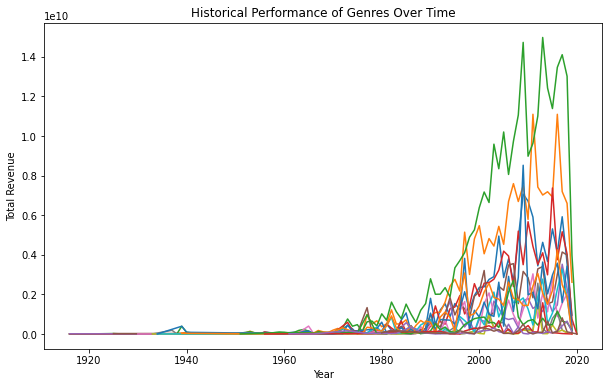

In [45]:
import matplotlib.pyplot as plt

# Plotting total revenue by genre over the years
plt.figure(figsize=(10, 6))
for genre in historical_performance['genre'].unique():
    genre_data = historical_performance[historical_performance['genre'] == genre]
    plt.plot(genre_data['release_year'], genre_data['total_revenue'], label=genre)

plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Historical Performance of Genres Over Time')
#plt.legend()
plt.show()


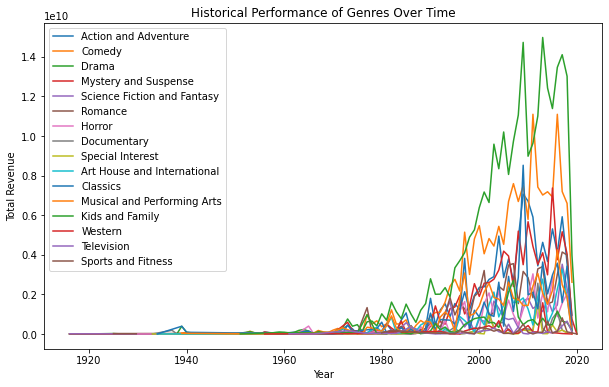

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for genre in historical_performance['genre'].unique():
    genre_data = historical_performance[historical_performance['genre'] == genre]
    plt.plot(genre_data['release_year'], genre_data['total_revenue'], label=genre)

plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Historical Performance of Genres Over Time')
plt.legend()
plt.show()
